In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from time import time

from models import Generator_FC, Generator_MNIST, Encoder, Decoder, Encoder_Mini, Decoder_Mini
from data import load_MNIST

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data
labeling_loader, public_loader, private_loader, test_loader = load_MNIST(batch_size=64)

In [35]:
# Load model
model = Generator_FC(hidden_sizes=[128], nz=100).to(device)
model.load_state_dict(torch.load(
    "/home/jason/p2/runs_gen_fc_3/public_128_100_32_1_inf_1e-06_0.0_0.01_5e-05_0.0_64_3_500000_LeakyReLU_0.0/netG_500000.pt"
))

[128]


<All keys matched successfully>

In [36]:
load_mini = True
if not load_mini:
    # Load Encoder and Decoder
    run_fp = "runs/autoencoder"
    enc = Encoder(latent_size=100).to(device)
    dec = Decoder(latent_size=100).to(device)

    enc.load_state_dict(torch.load(os.path.join(run_fp, "enc.pth")))
    dec.load_state_dict(torch.load(os.path.join(run_fp, "dec.pth")))
else:
    # Load mini model
    run_fp = "runs/autoencoder_mini"
    enc = Encoder_Mini(latent_size=100).to(device)
    dec = Decoder_Mini(latent_size=100).to(device)

    enc.load_state_dict(torch.load(os.path.join(run_fp, "enc.pth")))
    dec.load_state_dict(torch.load(os.path.join(run_fp, "dec.pth")))

In [37]:
def projected_gradient_ascent(model, imgs, latent_dim, lr=1e-2, iterations=1000, z_0_mult=1):
    """Perform projected gradient ascent on an image to find the optimal latent vector
    model: Generator taking (batch_size, latent_dim) -> (batch_size, 1, 28, 28)
    imgs: (batch_size, 1, 28, 28)
    latent_dim: int
    """
    batch_size = imgs.shape[0]
    # Setup latent vector
    latent_vectors = torch.randn(batch_size, latent_dim).to(device)
    latent_vectors.requires_grad = True

    # Sample z_0 and calculate P_Z(z_0)
    z_0 = torch.randn(batch_size, latent_dim).to(device) * z_0_mult
    norm_z_0 = torch.linalg.norm(z_0, dim=1)

    # min max norms
    print(f"Min norm: {torch.min(norm_z_0).item()}")
    print(f"Max norm: {torch.max(norm_z_0).item()}")

    # Setup optimizer and loss
    optimizer = optim.SGD([latent_vectors], lr=lr)
    criterion = nn.MSELoss()

    # Train
    model.eval()
    for i in range(iterations):
        optimizer.zero_grad()
        output = model(latent_vectors)
        loss = criterion(output, imgs)
        loss.backward()
        optimizer.step()

        # Project any latent vector outside of sphere to the surface of the sphere
        with torch.no_grad():
            norm_latent_vectors = torch.linalg.norm(latent_vectors, dim=1)
            scale = norm_latent_vectors / norm_z_0
            scale = torch.where(scale < 1, torch.ones_like(scale), scale)
            latent_vectors = latent_vectors / scale.unsqueeze(1)

        if i % 50 == 0:
            print(f"Iteration: {i} Loss: {loss.item()}")

    return latent_vectors

# Regular gradient ascent
def gradient_ascent(model, imgs, latent_dim, lr=1e-2, iterations=1000, latent_vectors=None):
    """Perform gradient ascent on an image to find the optimal latent vector
    model: Generator taking (batch_size, latent_dim) -> (batch_size, 1, 28, 28)
    imgs: (batch_size, 1, 28, 28)
    latent_dim: int
    """
    batch_size = imgs.shape[0]
    # Setup latent vector
    if latent_vectors is None:
        latent_vectors = torch.randn(batch_size, latent_dim).to(device)
    latent_vectors.requires_grad = True

    # Setup optimizer and loss
    optimizer = optim.SGD([latent_vectors], lr=lr)
    criterion = nn.MSELoss()

    # Train
    model.eval()
    prev_loss = float("inf")
    for i in range(iterations):
        optimizer.zero_grad()
        output = model(latent_vectors)
        loss = criterion(output, imgs)
        loss.backward()
        optimizer.step()

        if i % 5000 == 0:
            print(f"Iteration: {i} Loss: {loss.item()}")
            # if loss increases, stop
            if i > 0 and loss.item() > prev_loss:
                print("Loss increased, stopping")
                break
            prev_loss = loss.item()

    return latent_vectors

In [38]:
# Get image
train_loader = private_loader
# train_loader = public_loader
imgs, _ = next(iter(train_loader))
imgs = imgs.to(device)

In [ ]:
# Run gradient ascent on decoder
latent_vectors = gradient_ascent(dec, imgs, 100, lr=100.0, iterations=100000)

In [ ]:
latent_vectors = gradient_ascent(dec, imgs, 100, lr=50.0, 
    iterations=100000, latent_vectors=latent_vectors)

In [27]:
gradient_ascent_imgs = dec(latent_vectors).cpu().detach().numpy()

In [29]:
# Reconstruct image using encoder
autoencoder_imgs = dec(enc(imgs)).cpu().detach().numpy()

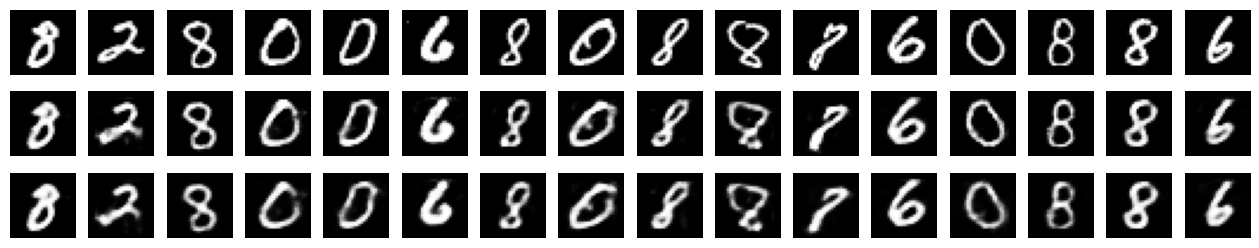

In [30]:
# Show first 16 images, gradient ascent, autoencoder
fig, axs = plt.subplots(3, 16, figsize=(16, 3))
for i in range(16):
    axs[0, i].imshow(imgs[i].cpu().detach().numpy().squeeze(), cmap="gray")
    axs[1, i].imshow(gradient_ascent_imgs[i].squeeze(), cmap="gray")
    axs[2, i].imshow(autoencoder_imgs[i].squeeze(), cmap="gray")
    for ax in axs[:, i]:
        ax.axis("off")
plt.show()

In [39]:
# # Perform gradient ascent
latent_vectors = projected_gradient_ascent(model, imgs, 100, lr=1e-2, iterations=1)

Min norm: 8.868768692016602
Max norm: 11.79673957824707
Iteration: 0 Loss: 0.11256223917007446


In [ ]:
reconstructed_imgs = model(latent_vectors).cpu().detach().numpy()

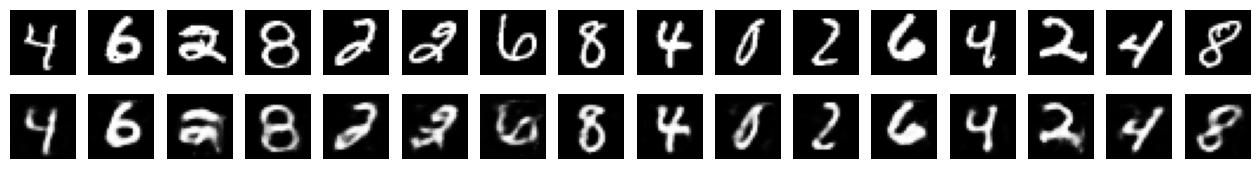

In [20]:
# Show first 16 images and reconstructed images
imgs = imgs.cpu().detach().numpy()

fig, axs = plt.subplots(2, 16, figsize=(16, 2))
for i in range(16):
    axs[0, i].imshow(imgs[i, 0], cmap="gray")
    axs[1, i].imshow(reconstructed_imgs[i, 0], cmap="gray")
    axs[0, i].axis("off")
    axs[1, i].axis("off")
plt.show()


In [ ]:
# Process 